Importações

In [67]:
from datetime import datetime
from itertools import combinations
import locale
import sqlite3

from matplotlib import pyplot as plt
import pandas as pd
import unidecode

Leitura do db em formato de dataframe

In [68]:
def tratamento_da_cidade(valor):
    return unidecode.unidecode(valor.capitalize().replace('-', '').replace(' ', '').replace(',', ', '))

conn = sqlite3.connect("db_sorteios.db") 
sql_query = pd.read_sql_query (
    'SELECT * FROM sorteios',
    conn
)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df = pd.DataFrame(
    sql_query,
    columns=[
        "nr_sorteio",
        "mega_da_virada",
        "data_sorteio",
        "dezenas",
        "local_do_sorteio",
        "ganhadores_seis_dezenas",
        "premio_seis_dezenas",
        "ganhadores_cinco_dezenas",
        "premio_cinco_dezenas",
        "ganhadores_quatro_dezenas",
        "premio_quatro_dezenas",
    ],
)
df["local_do_sorteio"] = df["local_do_sorteio"].apply(lambda x: tratamento_da_cidade(x))

Ocorrências de cada dezena em apostas que premiaram Sena

In [ ]:
def adicionar_ao_dicionario(valor):
    if valor in temp_dict:
        temp_dict[valor] += 1
    else:
        temp_dict[valor] = 1

df_graf_1 = df[(df["ganhadores_seis_dezenas"] != 0) & (df["mega_da_virada"] == 0)]
temp_dict = {}

df_graf_1["dezenas"].str.split(', ', expand=True).map(lambda x: adicionar_ao_dicionario(x))

temp_dict = dict(sorted(temp_dict.items()))

figura = plt.figure(figsize=(20, 7))
plt.bar(list(temp_dict), temp_dict.values(), width=0.5)
plt.title("Ocorrências de cada dezena em apostas que premiaram Sena")
plt.yticks([i for i in range(30, 76, 5)])
plt.ylim([30, 75])
plt.show()

Cidades com o maior número de ganhadores da Sena

In [ ]:
df_graf_2 = df[(df["ganhadores_seis_dezenas"] != 0) & (df["mega_da_virada"] == 0)]
df2 = df_graf_2['local_do_sorteio'].value_counts()
grafico_cidades = df2.head(15).iloc[::-1].plot(
    kind='barh',
    title="Cidades com o maior número de ganhadores da Sena",
    xticks=range(0, 121, 5),
    figsize=(10, 5),
    ylabel="Cidade vencedora",
    width=0.5
)
plt.show(grafico_cidades)

Gráficos de Premiações da Sena

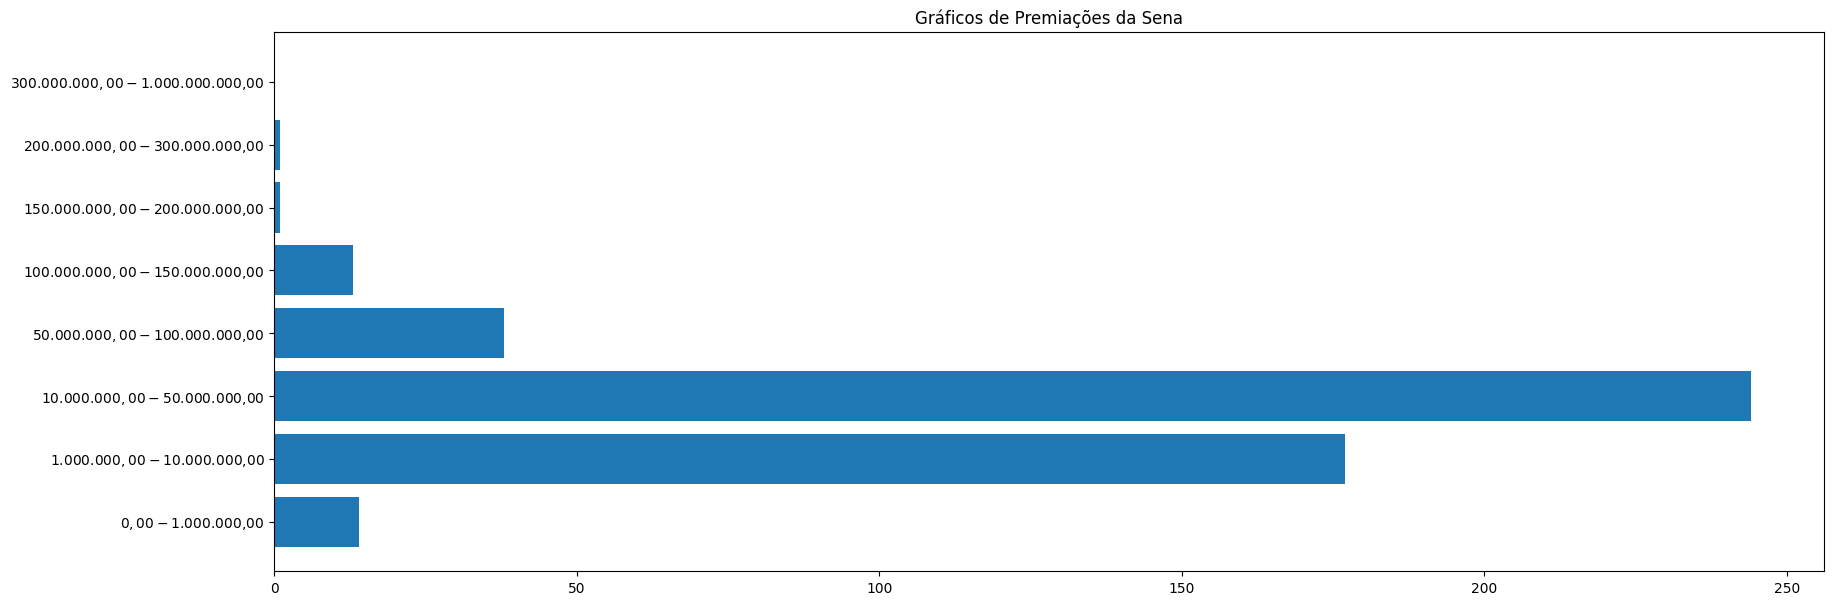

In [85]:
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
df_graf_3 = df[(df["ganhadores_seis_dezenas"] != 0) & (df["mega_da_virada"] == 0)]
df3 = df_graf_3.sort_values("premio_seis_dezenas")
lista_referencia = [0, 1, 10, 50, 100, 150, 200, 300, 1000]
lista_referencia = [i*1000000 for i in lista_referencia]
lista_valores = [(lista_referencia[i], lista_referencia[i+1]) for i in range(len(lista_referencia)) if i < 8]
lista_len_dfs = []
for i in lista_valores:
    temp_df = df3[(df3["premio_seis_dezenas"] > i[0]) & (df3["premio_seis_dezenas"] < i[1])]
    lista_len_dfs.append(len(temp_df))
lista_valores_locale = [(locale.currency(i[0], grouping=True), locale.currency(i[1], grouping=True)) for i in lista_valores]
lista_valores_locale = [f"{i[0].replace(' ', '').replace('R', '')}-{i[1].replace(' ', '').replace('R', '')}" for i in lista_valores_locale]

figura = plt.figure(figsize=(20, 7))
plt.barh(lista_valores_locale, lista_len_dfs)
plt.title("Gráficos de Premiações da Sena")
plt.show()